In [1]:
from datetime import datetime
from functools import partial
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import numpy as np
import joblib
from tqdm.notebook import tqdm

from sim.incentive import assemble_W, assemble_S, compute_incentive
from sim.subnet_data import get_wandb_history
from sim.plotting import plot_metric, plot_multi_validator_metric, plot_incentive, plot_incentives
from sim.blocks import average_challenges_per_tempo
from sim import Simulator, run_simulations

[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


2024-10-04 09:35:02.326 |       INFO       |  - You are connecting to finney network with endpoint wss://entrypoint-finney.opentensor.ai:443. - 
2024-10-04 09:35:02.326 |     WARNING      |  - We strongly encourage running a local subtensor node whenever possible. This increases decentralization and resilience of the network. - 
2024-10-04 09:35:02.326 |     WARNING      |  - In a future release, local subtensor will become the default endpoint. To get ahead of this change, please run a local subtensor node and point to it. - 
2024-10-04 09:35:02.420 |       INFO       |  - Connected to finney network and wss://entrypoint-finney.opentensor.ai:443. - 
2024-10-04 09:35:04.448 |       INFO       |  - You are connecting to finney network with endpoint wss://entrypoint-finney.opentensor.ai:443. - 
2024-10-04 09:35:04.448 |     WARNING      |  - We strongly encourage running a local subtensor node whenever possible. This increases decentralization and resilience of the network. - 
2024-10-04

## Query W&B or Load Locally Cached Data

In [2]:
# `load_cached_history` = True will read local pickle file at fname
# `load_cached_history` = False will query W&B
load_cached_history = True 
write_to_history_cache = True
fname = 'vali_histories_shorts.pkl'

#  Earlist time (epoch) from which to pull W&B runs
start_ts = 1727940981 # 1727803270  #1727846400 # 1727886242 #

# Names of W&B runs to query
VALIDATOR_UIDS = [131, 193]#, 107]#, 19, 107] # [6, 17, 19, 20, 107, , 236, 250, 20, 122
VALIDATORS = [f'validator-{uid}-1.1.0' for uid in VALIDATOR_UIDS]

# Keys will be validator names, values will be history dataframes
HISTORY_DFS = {}


In [3]:
if load_cached_history:
    HISTORY_DFS = joblib.load(fname)
else:
    for vali in VALIDATORS:
        print(f"Loading data from {vali}")
        HISTORY_DFS[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=None, 
            verbosity=0)

    if write_to_history_cache:
        joblib.dump(HISTORY_DFS, fname)

for vali, history_df in HISTORY_DFS.items():
    print(vali)
    avg, counts = average_challenges_per_tempo(history_df)
    format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
    print(f'\tDate Range: {format_time(history_df._timestamp.min())} : {format_time(history_df._timestamp.max())}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')


validator-131-1.1.0
	Date Range: 2024-10-03T03:32:30 : 2024-10-04T07:37:24
	DataFrame shape: (1371, 4)
	Average Challenges Per Tempo: 57.125
		Challenges Per Tempo: [58, 61, 61, 58, 59, 59, 59, 57, 59, 59, 58, 56, 59, 61, 58, 59, 59, 59, 58, 58, 57, 57, 59, 23]
validator-193-1.1.0
	Date Range: 2024-10-03T02:40:36 : 2024-10-04T07:38:05
	DataFrame shape: (1439, 4)
	Average Challenges Per Tempo: 57.56
		Challenges Per Tempo: [60, 59, 60, 59, 60, 58, 59, 60, 59, 60, 60, 59, 60, 60, 60, 59, 58, 60, 60, 59, 59, 61, 61, 61, 8]


In [4]:
for v in VALIDATORS:
    HISTORY_DFS[v] = HISTORY_DFS[v].iloc[:50]

## Run Simulation or Load Simulation Results

In [6]:
# `load_cached_scores` = False will run simulations for each validator with the specified reward functions in parallel
# `load_cached_scores` = True will read local pickle file
load_cached_scores = True  

# `write_to_cache` = True will overwrite scored_fname
write_to_cache = True
scored_fname = 'histories_scored_test.pkl'

# Number of dataframe rows over which to compute rewards and scores, set to `None` for all rows
score_num_challenges = None

REWARD_FNS = ['BinaryReward', 'WeightedHistoryReward']

# Keys are validator (w&b run) names, values are dataframes with reward & score columns
SCORED_DFS = {}

In [7]:
if load_cached_scores:
    SCORED_DFS = joblib.load(scored_fname)
else:  
    SCORED_DFS = run_simulations(HISTORY_DFS, REWARD_FNS)

    if write_to_cache:
        joblib.dump(SCORED_DFS, scored_fname)

In [8]:
from sim.weights import U16_MAX

for vali, scored_df in SCORED_DFS.items(): 
    for col in scored_df.columns:
        if 'weights' in col:
            scored_df.loc[:, col + '_norm'] = scored_df.loc[:, col].apply(lambda l: [v/U16_MAX for v in l])

WEIGHT_SET_DFS = {vali: df.iloc[::50] for vali, df in SCORED_DFS.items()}

## Plot Incentive


In [13]:
INCENTIVES = {}


for reward_cls in REWARD_FNS:
    S = assemble_S(VALIDATOR_UIDS)
    W = assemble_W(SCORED_DFS, f'weights_{reward_cls}')
    I = compute_incentive(W, S)
    INCENTIVES[reward_cls] = np.sort(I[I.nonzero()])


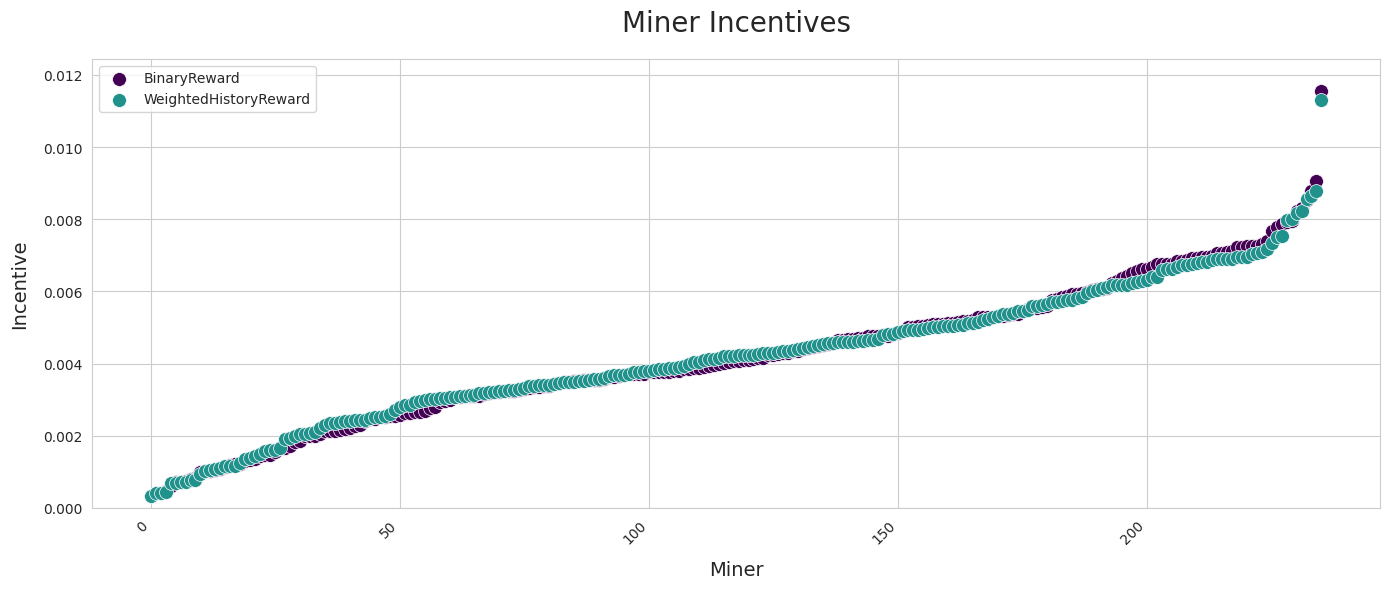

In [14]:
plot_incentives(INCENTIVES)